## see
https://www.youtube.com/watch?v=QIUxPv5PJOY

# Programm for closing stock price prediction with ANN (Long Short Term Memory [LSTM]) by using stock history

## Load Modules and Data 

In [2]:
%autosave 1

Autosaving every 1 seconds


In [3]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import date
import tensorflow as tf

plt.style.use("fivethirtyeight")


df_shape:  (5488, 6)
                  High         Low        Open       Close       Volume  \
Date                                                                      
2000-01-03    1.004464    0.907924    0.936384    0.999442  535796800.0   
2000-01-04    0.987723    0.903460    0.966518    0.915179  512377600.0   
2000-01-05    0.987165    0.919643    0.926339    0.928571  778321600.0   
2000-01-06    0.955357    0.848214    0.947545    0.848214  767972800.0   
2000-01-07    0.901786    0.852679    0.861607    0.888393  460734400.0   
...                ...         ...         ...         ...          ...   
2021-10-18  146.839996  143.160004  143.449997  146.550003   85589200.0   
2021-10-19  149.169998  146.550003  147.009995  148.759995   76378900.0   
2021-10-20  149.750000  148.119995  148.699997  149.259995   58418800.0   
2021-10-21  149.639999  147.869995  148.809998  149.479996   61421000.0   
2021-10-22  150.179993  148.639999  149.690002  148.690002   57045863.0   

   

Text(0, 0.5, 'Close Price [$]')

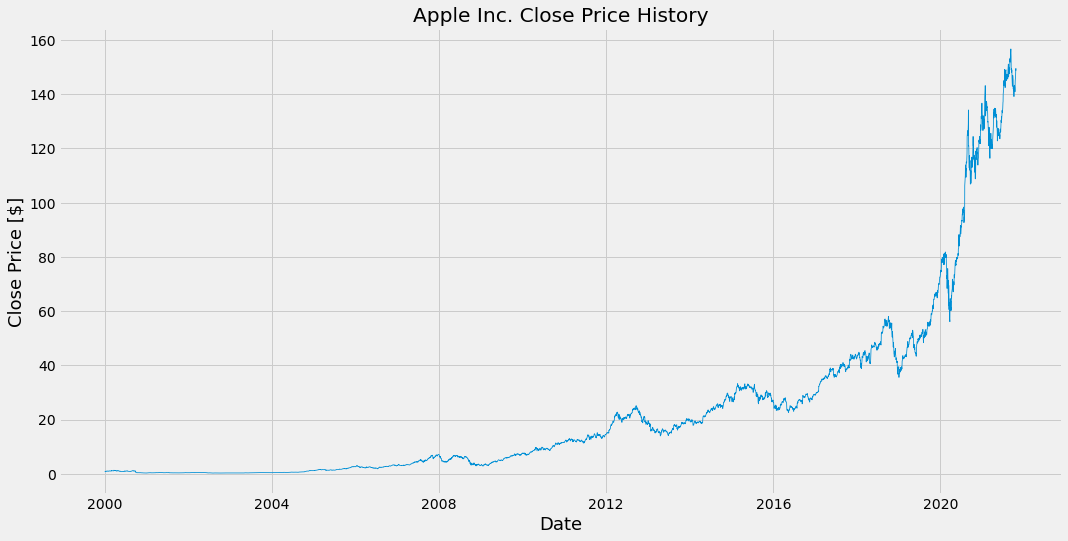

In [4]:
start_date = "2000-01-01"
end_date = date.today() 
df = web.DataReader("AAPL", data_source="yahoo", start=start_date, end=end_date)
print("df_shape: ", df.shape)
print(df)
plt.figure(figsize=(16, 8))
plt.title("Apple Inc. Close Price History")
plt.plot(df["Close"], linewidth=0.8)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price [$]", fontsize=18)

## Prepare Training Data

In [5]:
# get only "close" coulumn
data = df.filter(["Close"])

# convert df to np-array
dataset = data.values

# set number of training data (rows) to 80%
training_data_len = math.ceil(len(dataset) * .8)  # ceil() rounds up integer
print(f"training_data_len: {training_data_len}\n{dataset}")

training_data_len: 4391
[[  0.99944198]
 [  0.91517901]
 [  0.92857099]
 ...
 [149.25999451]
 [149.47999573]
 [148.69000244]]


In [7]:
dataset.shape

(5488, 1)

In [6]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00489056],
       [0.00435199],
       [0.00443758],
       ...,
       [0.95251047],
       [0.95391663],
       [0.94886732]])

In [9]:
# Create training data set
train_data = scaled_data[:training_data_len, :]
# rows up to training_data_len, every column

# Split data into x_train and y_train; x = training data (independent variable),
# y = traget (dependent) variable
x_train = []
y_train = []

# x_train = data of 60 days (interating forward); y_train = the value that will follow
# the past 60 days
history_days = 60
predicting_days = 1

for i in range(history_days, len(train_data)):
    x_train.append(train_data[i-history_days:i, 0])
    y_train.append(train_data[i:i + predicting_days, 0])
#     # show x and y for 3 steps of loop (62)
#     if i <=62:
#         print(f"x_train len: {len(x_train[i - 60])}\n{x_train[i - 60]}")
#         print(f"y_train len: {len(y_train[i - 60])}\n{y_train[i - 60]}\n")


In [10]:
# Convert x_train and y_train to numpay arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# shuffle indexes
shuffled_idx = np.random.permutation(x_train.shape[0])

# shuffle x and y
x_train[:] = x_train[shuffled_idx]
y_train[:] = y_train[shuffled_idx]

for index in range(0, x_train.shape[0]):
    print(
        f"x:\
        \n{x_train[index, :]}\
        \ny:\
        \n{y_train[index, :]}\n"
    )

x:        
[0.09041125 0.08937034 0.08839105 0.0890188  0.09191555 0.09403162
 0.09455893 0.09378737 0.09324637 0.09491275 0.09454295 0.09604041
 0.09586236 0.09607465 0.09670468 0.09672978 0.09706078 0.09550626
 0.0958167  0.09414577 0.09905815 0.09859933 0.09916772 0.10071997
 0.1019823  0.10180196 0.10274929 0.10408696 0.10566431 0.10470557
 0.10464394 0.10373771 0.10224024 0.10518723 0.11025713 0.11229558
 0.1121609  0.11316986 0.1144048  0.11288224 0.11317671 0.11331366
 0.11287083 0.11331595 0.11003341 0.11056072 0.11074334 0.10972069
 0.11003113 0.11233895 0.11155826 0.11223166 0.11404641 0.11141445
 0.10526713 0.10640391 0.10462568 0.10125183 0.10243884 0.10457546]        
y:        
[0.10631488]

x:        
[0.01332874 0.01323058 0.01323971 0.01333102 0.01368712 0.0138218
 0.01433085 0.01440389 0.01404779 0.01398387 0.01484674 0.01508186
 0.01489696 0.015406   0.01538317 0.01541285 0.01546992 0.01560231
 0.01561829 0.01494033 0.01497913 0.01473489 0.01479652 0.01496315
 0.0152

x:        
[0.00055127 0.0004942  0.00047822 0.00051133 0.00051589 0.00045996
 0.00041887 0.00046339 0.0004942  0.00053073 0.00049078 0.0005878
 0.00057866 0.00068481 0.0006871  0.00069394 0.00067796 0.000646
 0.00068139 0.00070421 0.0006403  0.00067796 0.00068139 0.00070193
 0.00068595 0.00077041 0.00083091 0.0007727  0.00073731 0.00076813
 0.00077384 0.00074074 0.00077041 0.00088797 0.00088341 0.00085487
 0.00087656 0.00087542 0.00084346 0.00096102 0.00089824 0.00086743
 0.00081721 0.00090852 0.00086857 0.00092335 0.00082862 0.00074302
 0.00077726 0.00074416 0.00074644 0.00075101 0.00080579 0.00078183
 0.00075215 0.00082405 0.00082177 0.00090053 0.000977   0.00088569]        
y:        
[0.00088341]

x:        
[0.00081265 0.00072818 0.00088455 0.00085259 0.00084689 0.00101808
 0.0009907  0.00106146 0.0009496  0.00083091 0.00110369 0.00143811
 0.00136049 0.00127033 0.00124522 0.00132397 0.00132055 0.00149289
 0.00141186 0.00146208 0.0015374  0.00135136 0.00144153 0.00135136
 0.001306

x:        
[0.01900811 0.01837124 0.01864973 0.01876158 0.0181658  0.01883006
 0.01871593 0.01852646 0.01801285 0.0182046  0.01785078 0.0174262
 0.01726641 0.0171089  0.01711119 0.01696281 0.01786904 0.01763164
 0.01805623 0.01791698 0.01801285 0.01963358 0.02064482 0.02037089
 0.02010153 0.02066764 0.02017686 0.01883463 0.01870451 0.01831417
 0.01806535 0.01829363 0.01819091 0.01799231 0.01812014 0.01803111
 0.01807221 0.01784622 0.0178485  0.0176636  0.01771154 0.01816808
 0.01817493 0.01751066 0.01787818 0.01783709 0.01797405 0.0179535
 0.01786676 0.01811101 0.0188643  0.01893507 0.01883463 0.0187068
 0.01766132 0.01781654 0.01837581 0.01799916 0.01820688 0.01863375]        
y:        
[0.01852646]

x:        
[0.02740392 0.02743131 0.02882148 0.02810243 0.0289242  0.03035318
 0.03068417 0.03161552 0.03051753 0.03114756 0.03125941 0.03263589
 0.03217021 0.03311069 0.03344625 0.03408769 0.03339146 0.03307188
 0.03378181 0.03209032 0.03223641 0.03237338 0.03358778 0.03376811
 0.035263

x:        
[0.17580511 0.1719382  0.17212995 0.17270518 0.17497421 0.17753084
 0.17762671 0.17403144 0.17024443 0.16933363 0.16968516 0.16783161
 0.16736822 0.16640948 0.16524301 0.15480875 0.15003104 0.14828933
 0.14812954 0.15059031 0.14900839 0.14749038 0.14665948 0.14677133
 0.147778   0.14632393 0.14285648 0.1431441  0.14851304 0.14788986
 0.14959961 0.14902436 0.15065422 0.15258768 0.15493658 0.15768497
 0.15894731 0.15885143 0.15806846 0.1558314  0.15464896 0.15496854
 0.15610304 0.1567422  0.1565984  0.1577329  0.15642263 0.15404175
 0.15423351 0.15372218 0.15437732 0.15082999 0.15046247 0.15175677
 0.15118153 0.15206037 0.14774605 0.14557291 0.14804964 0.14934395]        
y:        
[0.15126142]

x:        
[0.00587112 0.00597385 0.0064692  0.00651485 0.00656621 0.00647832
 0.00654452 0.00654795 0.00657876 0.006726   0.00674883 0.00679334
 0.00694628 0.00727956 0.00735146 0.00759115 0.00738342 0.00750098
 0.00751239 0.0077361  0.00748956 0.0074462  0.00777148 0.00816182
 0.008

x:        
[0.01809959 0.01824112 0.01872734 0.01911768 0.019419   0.01894192
 0.01946009 0.01945781 0.01942585 0.01934824 0.01930259 0.01933683
 0.01900811 0.01837124 0.01864973 0.01876158 0.0181658  0.01883006
 0.01871593 0.01852646 0.01801285 0.0182046  0.01785078 0.0174262
 0.01726641 0.0171089  0.01711119 0.01696281 0.01786904 0.01763164
 0.01805623 0.01791698 0.01801285 0.01963358 0.02064482 0.02037089
 0.02010153 0.02066764 0.02017686 0.01883463 0.01870451 0.01831417
 0.01806535 0.01829363 0.01819091 0.01799231 0.01812014 0.01803111
 0.01807221 0.01784622 0.0178485  0.0176636  0.01771154 0.01816808
 0.01817493 0.01751066 0.01787818 0.01783709 0.01797405 0.0179535 ]        
y:        
[0.01786676]

x:        
[0.09670468 0.09672978 0.09706078 0.09550626 0.0958167  0.09414577
 0.09905815 0.09859933 0.09916772 0.10071997 0.1019823  0.10180196
 0.10274929 0.10408696 0.10566431 0.10470557 0.10464394 0.10373771
 0.10224024 0.10518723 0.11025713 0.11229558 0.1121609  0.11316986
 0.1144

x:        
[0.01064655 0.01079265 0.01070133 0.01016262 0.01045024 0.01074014
 0.01092961 0.0107721  0.01055068 0.01030415 0.01021284 0.01000055
 0.01027904 0.00974489 0.01076982 0.01082917 0.01070133 0.01042057
 0.01104374 0.01131767 0.0112081  0.01146604 0.01130854 0.01152083
 0.01115103 0.01093646 0.01164866 0.01162811 0.01218738 0.0126211
 0.01246131 0.01225129 0.01217597 0.01222391 0.01246815 0.01255033
 0.01252979 0.01271925 0.01332874 0.01323058 0.01323971 0.01333102
 0.01368712 0.0138218  0.01433085 0.01440389 0.01404779 0.01398387
 0.01484674 0.01508186 0.01489696 0.015406   0.01538317 0.01541285
 0.01546992 0.01560231 0.01561829 0.01494033 0.01497913 0.01473489]        
y:        
[0.01479652]

x:        
[0.03810754 0.03740447 0.03830385 0.04099745 0.04094495 0.04022589
 0.04066418 0.0407532  0.0411892  0.0418626  0.04128964 0.04138779
 0.04100202 0.04228262 0.04102941 0.03855724 0.0362517  0.03360148
 0.03729946 0.03642062 0.03600745 0.03648454 0.03592755 0.03704608
 0.0369


x:        
[0.13220994 0.13036778 0.13137903 0.12879272 0.12908034 0.12964416
 0.12840009 0.13181274 0.13375761 0.13533039 0.13773409 0.1368073
 0.13863576 0.13733918 0.13647632 0.13521398 0.13659958 0.13704243
 0.13704928 0.13689406 0.13873392 0.13644665 0.13633935 0.13567509
 0.12975146 0.12973092 0.13207753 0.13433057 0.13792127 0.1370196
 0.1372433  0.13904893 0.14061258 0.14023822 0.13999854 0.14019713
 0.14041855 0.1423132  0.14269897 0.14250266 0.14376044 0.14644719
 0.15033693 0.14826194 0.15118609 0.14976168 0.14989636 0.15274062
 0.15253974 0.15223614 0.15004473 0.15035747 0.15257854 0.15149655
 0.1528753  0.15382719 0.1497868  0.14929601 0.15139609 0.154407  ]        
y:        
[0.15630165]

x:        
[0.01042969 0.01006903 0.01045709 0.01057807 0.010852   0.01231293
 0.01236315 0.01252294 0.01263936 0.0130822  0.01297492 0.01347483
 0.01401583 0.01383778 0.01406149 0.01438791 0.01409344 0.01384463
 0.01328993 0.01301828 0.01312786 0.01303198 0.01309818 0.01367114
 0.0140

x:        
[0.00440192 0.00468012 0.00440905 0.00471579 0.00435199 0.00448039
 0.00458739 0.00439478 0.00441618 0.00471579 0.00502253 0.00500113
 0.00522226 0.0049512  0.00508673 0.00515807 0.00503679 0.00451605
 0.00479426 0.00461592 0.00405951 0.00421645 0.00421645 0.00443758
 0.00401671 0.00430205 0.00413084 0.00389544 0.00398104 0.00390971
 0.00397391 0.00383837 0.00392397 0.00393111 0.00394538 0.00387404
 0.00383124 0.00403811 0.00437338 0.00420931 0.00426638 0.00440192
 0.00470152 0.00490661 0.00498686 0.00512953 0.00525794 0.0052936
 0.00545767 0.00574301 0.00562887 0.00517233 0.00557894 0.00522226
 0.00517233 0.00509386 0.0051224  0.00499221 0.00480674 0.00542557]        
y:        
[0.00534354]

x:        
[0.03930596 0.03979674 0.03851158 0.03802993 0.03805047 0.03899551
 0.0369114  0.03732914 0.03672422 0.0383769  0.03689314 0.03733598
 0.03848647 0.03948858 0.03827874 0.03882203 0.03789753 0.03819428
 0.03722641 0.03795003 0.03772176 0.03620148 0.03646171 0.03548699
 0.0364


x:        
[0.11809366 0.11841552 0.11654142 0.11800464 0.11727189 0.11303746
 0.10942394 0.11402815 0.11324975 0.11263799 0.11372684 0.11583606
 0.10133858 0.09891434 0.10118564 0.10311224 0.10278353 0.10247765
 0.10205078 0.09947132 0.10301409 0.10290224 0.10538354 0.10692665
 0.10805658 0.10531049 0.10510733 0.10501146 0.10354368 0.10350486
 0.10096193 0.10032505 0.10140934 0.09958089 0.10098932 0.09998493
 0.09926131 0.09676631 0.09438773 0.09691925 0.09566833 0.09679142
 0.09705165 0.09845551 0.09630064 0.09628238 0.09722971 0.09977721
 0.10253016 0.10224938 0.10169924 0.10184762 0.10394315 0.10432436
 0.10376738 0.10169924 0.09954894 0.09641021 0.09661109 0.09711328]        
y:        
[0.09613856]

x:        
[0.01051872 0.01064427 0.01039773 0.0103498  0.01064655 0.01079265
 0.01070133 0.01016262 0.01045024 0.01074014 0.01092961 0.0107721
 0.01055068 0.01030415 0.01021284 0.01000055 0.01027904 0.00974489
 0.01076982 0.01082917 0.01070133 0.01042057 0.01104374 0.01131767
 0.011


x:        
[3.08138468e-05 1.36972336e-05 0.00000000e+00 2.28180873e-06
 4.45109852e-05 5.25005540e-05 3.65215117e-05 2.62502294e-05
 8.44584482e-05 1.07282821e-04 1.25549863e-04 1.41528810e-04
 1.51800093e-04 3.38977745e-04 4.99911454e-04 5.17034448e-04
 5.56982006e-04 5.91221709e-04 6.20897795e-04 6.33450886e-04
 6.19753747e-04 6.40296312e-04 6.48285785e-04 5.68390859e-04
 5.33013395e-04 5.39858821e-04 5.84369807e-04 5.93503518e-04
 6.57419306e-04 5.88939900e-04 5.68390859e-04 5.51274151e-04
 4.94203789e-04 4.78224842e-04 5.11326783e-04 5.15890401e-04
 4.59964086e-04 4.18872480e-04 4.63389942e-04 4.94203789e-04
 5.30725300e-04 4.90777933e-04 5.87795663e-04 5.78662142e-04
 6.84813583e-04 6.87095392e-04 6.93940818e-04 6.77961871e-04
 6.46003977e-04 6.81387727e-04 7.04212100e-04 6.40296312e-04
 6.77961871e-04 6.81387727e-04 7.01930292e-04 6.85951344e-04
 7.70409697e-04 8.30906106e-04 7.72697983e-04 7.37314042e-04]        
y:        
[0.00076813]

x:        
[0.02125202 0.0216766  0.021

x:        
[0.0993549  0.09868835 0.09839388 0.09715894 0.09801952 0.09667044
 0.09711556 0.09706306 0.09506113 0.09365498 0.09289255 0.09039071
 0.09041125 0.08937034 0.08839105 0.0890188  0.09191555 0.09403162
 0.09455893 0.09378737 0.09324637 0.09491275 0.09454295 0.09604041
 0.09586236 0.09607465 0.09670468 0.09672978 0.09706078 0.09550626
 0.0958167  0.09414577 0.09905815 0.09859933 0.09916772 0.10071997
 0.1019823  0.10180196 0.10274929 0.10408696 0.10566431 0.10470557
 0.10464394 0.10373771 0.10224024 0.10518723 0.11025713 0.11229558
 0.1121609  0.11316986 0.1144048  0.11288224 0.11317671 0.11331366
 0.11287083 0.11331595 0.11003341 0.11056072 0.11074334 0.10972069]        
y:        
[0.11003113]

x:        
[2.87621333e-04 2.81913669e-04 3.62946165e-04 3.22998798e-04
 2.88759095e-04 2.45392157e-04 2.75061956e-04 3.68653830e-04
 3.29850510e-04 3.25286892e-04 2.61371104e-04 2.96748568e-04
 2.71642386e-04 2.35114398e-04 2.32832780e-04 2.11145978e-04
 1.72342657e-04 2.08864169e-04

x:        
[0.15382719 0.1497868  0.14929601 0.15139609 0.154407   0.15630165
 0.15824195 0.15872816 0.15877154 0.15799541 0.15831271 0.15618978
 0.15225212 0.15034378 0.15402806 0.15078206 0.14902208 0.14946036
 0.15177502 0.15071357 0.14746984 0.14417818 0.14364859 0.14480364
 0.14187948 0.14224701 0.14339977 0.14683068 0.14564824 0.14291584
 0.13771127 0.14323313 0.13851477 0.13930687 0.13764278 0.13637816
 0.13439677 0.13467526 0.13016919 0.13195427 0.13155022 0.1258777
 0.12125521 0.12338041 0.12241483 0.12243081 0.12105662 0.11848628
 0.11895653 0.12764223 0.12654196 0.1267223  0.12895935 0.13307508
 0.13199079 0.13157078 0.13303627 0.13210493 0.13231265 0.12995233]        
y:        
[0.12149262]

x:        
[0.0004748  0.00048508 0.0004417  0.00036066 0.00044513 0.00029218
 0.00029789 0.00038007 0.00027621 0.0002317  0.00027278 0.00027278
 0.00027621 0.00022028 0.00021229 0.00031501 0.00034469 0.00035154
 0.00032871 0.0004223  0.00052731 0.00055812 0.00055584 0.00055812
 0.0004

x:        
[0.17136296 0.17344023 0.17328043 0.17302477 0.17280107 0.17324847
 0.17189026 0.17243354 0.17112327 0.17038824 0.16938157 0.16918982
 0.16787954 0.16803933 0.16904601 0.17064391 0.17059596 0.17165058
 0.16711255 0.16329358 0.16698472 0.17099543 0.1770994  0.18317141
 0.18213277 0.1799916  0.17997562 0.17994366 0.18165341 0.17860142
 0.17887306 0.17920862 0.18058281 0.17775454 0.17914472 0.17829782
 0.17906482 0.17914472 0.18048694 0.18075858 0.1839384  0.18433788
 0.18599968 0.18542445 0.18646307 0.18633525 0.18620741 0.18564815
 0.18555227 0.18481724 0.18649504 0.18745377 0.18320336 0.18142971
 0.1802153  0.17992768 0.17665199 0.17681178 0.17399949 0.17241756]        
y:        
[0.17492627]

x:        
[0.14822541 0.14910426 0.14848108 0.14597239 0.14435851 0.14582857
 0.14563683 0.14579662 0.14528529 0.14376729 0.14363946 0.14276061
 0.14288845 0.14375131 0.14547704 0.14699504 0.14793779 0.14787389
 0.14875272 0.15185264 0.15086194 0.15092586 0.1503666  0.15065422
 0.152


x:        
[0.01481478 0.01470749 0.01413681 0.01427606 0.01439248 0.01396104
 0.01344972 0.01363918 0.01349081 0.0130959  0.01292698 0.01349537
 0.01386974 0.01362092 0.01318264 0.01326254 0.01310959 0.01261196
 0.01258001 0.01223532 0.01218967 0.01208694 0.01190433 0.01273066
 0.01282654 0.01281969 0.01280371 0.01246587 0.01384463 0.01476456
 0.01443357 0.0141779  0.01402268 0.01373049 0.01367571 0.01329678
 0.01361864 0.01348853 0.0139405  0.01380582 0.01351135 0.01360722
 0.0140592  0.01433541 0.01457053 0.01439019 0.0148513  0.01474173
 0.01473945 0.01491294 0.01491294 0.01471662 0.01461847 0.0140592
 0.01395648 0.01397702 0.01333558 0.0133995  0.0129247  0.0132283 ]        
y:        
[0.01297035]

x:        
[0.129005   0.12639816 0.13774778 0.13722276 0.13614988 0.13180817
 0.13138588 0.13226471 0.13131511 0.12753266 0.12849825 0.1282015
 0.12842976 0.12873564 0.12786594 0.12592791 0.12477515 0.12315671
 0.11951351 0.11957285 0.12662642 0.12564258 0.12874479 0.12754864
 0.1268


x:        
[0.08467024 0.08523179 0.0863001  0.0873684  0.08820387 0.08992503
 0.09246568 0.09288114 0.09258211 0.09022635 0.09079247 0.09053452
 0.08964198 0.08912837 0.0876583  0.0855468  0.08401281 0.08353344
 0.08484601 0.08464513 0.08291712 0.08725654 0.08987709 0.09031081
 0.09173522 0.09483286 0.09437404 0.09488764 0.08949589 0.0887403
 0.08818332 0.09112802 0.08930185 0.08994786 0.09088148 0.09094084
 0.09090203 0.08901423 0.08921968 0.09051169 0.08986568 0.08974926
 0.09123302 0.08873346 0.08643705 0.0863001  0.08507656 0.08726112
 0.08633433 0.08465426 0.08409043 0.08273679 0.08444882 0.08227568
 0.08149499 0.08435978 0.08369324 0.08574767 0.08705567 0.08745971]        
y:        
[0.08821528]

x:        
[0.000646   0.00068139 0.00070421 0.0006403  0.00067796 0.00068139
 0.00070193 0.00068595 0.00077041 0.00083091 0.0007727  0.00073731
 0.00076813 0.00077384 0.00074074 0.00077041 0.00088797 0.00088341
 0.00085487 0.00087656 0.00087542 0.00084346 0.00096102 0.00089824
 0.000


x:        
[0.00080665 0.00067825 0.00071391 0.00081378 0.00077098 0.00067112
 0.00061405 0.00066398 0.00064972 0.00061405 0.00070678 0.00063545
 0.00056055 0.00050704 0.00038578 0.00044998 0.00040718 0.00044284
 0.0001361  0.0001361  0.0002217  0.00023597 0.00025738 0.00021457
 0.00015037 0.00010757 0.00012897 0.00010044 0.00014324 0.00010757
 0.00021457 0.00017891 0.00019317 0.00019317 0.00020031 0.00020031
 0.00037151 0.00044998 0.00037151 0.00039291 0.00046425 0.00039291
 0.00055698 0.00046425 0.00045711 0.00042144 0.00063545 0.00072818
 0.00069965 0.00084231 0.00084231 0.00077812 0.00073531 0.00097786
 0.00098499 0.00097072 0.00091365 0.00085659 0.00080665 0.00091365]        
y:        
[0.00087085]

x:        
[0.03647084 0.03713054 0.03709402 0.03717163 0.03671737 0.03718305
 0.03732    0.03689999 0.03623572 0.03620833 0.03652106 0.03737936
 0.03797742 0.03756882 0.03789297 0.03780166 0.03815776 0.03848647
 0.04001817 0.04062993 0.04073722 0.04050895 0.04061395 0.04084679
 0.04


x:        
[0.00109912 0.00115277 0.0011482  0.00110027 0.00112652 0.001082
 0.001082   0.00120983 0.00120641 0.00113793 0.0011151  0.00114478
 0.00111738 0.00113108 0.00114135 0.00107059 0.0010021  0.00096102
 0.00105119 0.00106146 0.00095189 0.00091422 0.00083204 0.00083319
 0.00082862 0.00081721 0.00091651 0.00086286 0.00086743 0.00088911
 0.00098042 0.00096102 0.00090281 0.00091651 0.00088226 0.00090509
 0.00083661 0.00082862 0.00092335 0.00088683 0.00080466 0.00079895
 0.00077155 0.00078981 0.00075101 0.00076813 0.00076356 0.00083204
 0.00087427 0.00091651 0.00093134 0.00094161 0.00093134 0.00103292
 0.00102379 0.00108086 0.00116875 0.00112765 0.00121098 0.00125549]        
y:        
[0.00126462]

x:        
[0.12664468 0.1264575  0.12506277 0.12576356 0.1251906  0.1242273
 0.12278691 0.12382782 0.12863749 0.12808508 0.1272245  0.12635478
 0.12508331 0.12656708 0.12476602 0.12199253 0.12266592 0.12177796
 0.12255864 0.12097444 0.12015723 0.12079411 0.12322748 0.1257316
 0.125021

x:        
[0.04411791 0.04371844 0.04297884 0.04299939 0.03960271 0.03905258
 0.03759393 0.03945434 0.03913933 0.03792264 0.03931281 0.03708945
 0.03494371 0.03522904 0.03533633 0.03403062 0.03024818 0.02945607
 0.02818004 0.02818004 0.02852929 0.02867539 0.02940129 0.02903377
 0.02855441 0.02803166 0.02635159 0.0261781  0.02714598 0.0280522
 0.02700445 0.0280408  0.02759795 0.02695194 0.02639268 0.02676704
 0.02624658 0.02577178 0.0258357  0.02570102 0.02657073 0.02815721
 0.02704097 0.02628996 0.02694966 0.02691998 0.02610734 0.02640866
 0.02582428 0.02757284 0.02727152 0.02770752 0.02740392 0.02743131
 0.02882148 0.02810243 0.0289242  0.03035318 0.03068417 0.03161552]        
y:        
[0.03051753]

x:        
[0.11976917 0.12002483 0.11965731 0.11958656 0.11969613 0.12087628
 0.12099498 0.11963449 0.118274   0.11874195 0.11980569 0.11977374
 0.11918936 0.12014125 0.12158393 0.12290789 0.1217186  0.12118901
 0.12105205 0.12102467 0.12214547 0.12235091 0.12149262 0.11990156
 0.1179

x:        
[0.01344972 0.01363918 0.01349081 0.0130959  0.01292698 0.01349537
 0.01386974 0.01362092 0.01318264 0.01326254 0.01310959 0.01261196
 0.01258001 0.01223532 0.01218967 0.01208694 0.01190433 0.01273066
 0.01282654 0.01281969 0.01280371 0.01246587 0.01384463 0.01476456
 0.01443357 0.0141779  0.01402268 0.01373049 0.01367571 0.01329678
 0.01361864 0.01348853 0.0139405  0.01380582 0.01351135 0.01360722
 0.0140592  0.01433541 0.01457053 0.01439019 0.0148513  0.01474173
 0.01473945 0.01491294 0.01491294 0.01471662 0.01461847 0.0140592
 0.01395648 0.01397702 0.01333558 0.0133995  0.0129247  0.0132283
 0.01297035 0.01291785 0.01296122 0.01318721 0.01300916 0.01247729]        
y:        
[0.01214629]

x:        
[0.00160018 0.00161844 0.00160589 0.00159104 0.00154311 0.00159104
 0.00152371 0.0015511  0.00159675 0.001623   0.00174513 0.00175654
 0.00171774 0.00170518 0.00170518 0.00180334 0.00174399 0.00178736
 0.00190492 0.00196655 0.00194943 0.00201107 0.0019403  0.00200536
 0.00223


x:        
[0.03568559 0.03706662 0.03724696 0.03781992 0.03846136 0.03821026
 0.0395913  0.03980588 0.04067102 0.04111159 0.04018252 0.04074635
 0.04037884 0.04145399 0.04186488 0.04102028 0.04181237 0.04133072
 0.04041308 0.0409381  0.03917813 0.0389179  0.03985838 0.04105908
 0.04119148 0.04111843 0.04158867 0.04098376 0.04081712 0.04077603
 0.0417439  0.04087875 0.03995882 0.04087875 0.0397762  0.03805276
 0.03784959 0.03886996 0.03991773 0.03930596 0.03979674 0.03851158
 0.03802993 0.03805047 0.03899551 0.0369114  0.03732914 0.03672422
 0.0383769  0.03689314 0.03733598 0.03848647 0.03948858 0.03827874
 0.03882203 0.03789753 0.03819428 0.03722641 0.03795003 0.03772176]        
y:        
[0.03620148]

x:        
[0.1238301  0.12224819 0.1188013  0.11809366 0.11841552 0.11654142
 0.11800464 0.11727189 0.11303746 0.10942394 0.11402815 0.11324975
 0.11263799 0.11372684 0.11583606 0.10133858 0.09891434 0.10118564
 0.10311224 0.10278353 0.10247765 0.10205078 0.09947132 0.10301409
 0.10


x:        
[1.15272295e-04 1.66634992e-04 2.06582360e-04 1.36958907e-04
 1.41528810e-04 1.75768704e-04 1.68916801e-04 1.51800093e-04
 1.49518284e-04 1.17560390e-04 1.40384763e-04 1.40384763e-04
 1.44948380e-04 1.62071375e-04 1.76906275e-04 2.45392157e-04
 1.97455316e-04 1.88321604e-04 2.14571834e-04 1.84895748e-04
 2.16853642e-04 1.57507948e-04 1.98592887e-04 2.15716072e-04
 1.74624466e-04 1.64353184e-04 1.71198610e-04 1.64353184e-04
 1.60927328e-04 1.42666572e-04 1.26687625e-04 1.25549863e-04
 1.82613939e-04 1.89465842e-04 2.15716072e-04 2.14571834e-04
 2.08864169e-04 2.04300742e-04 2.14571834e-04 1.42666572e-04
 1.63209136e-04 1.47230189e-04 1.56363710e-04 1.65497421e-04
 1.16416342e-04 1.18698151e-04 1.68916801e-04 1.52937854e-04
 1.47230189e-04 1.56363710e-04 1.51800093e-04 1.22124007e-04
 1.42666572e-04 9.12723493e-06 5.25005540e-05 3.08138468e-05
 1.36972336e-05 0.00000000e+00 2.28180873e-06 4.45109852e-05]        
y:        
[5.2500554e-05]

x:        
[0.0019403  0.00200536 0.

x:        
[1.08426869e-04 1.38102954e-04 1.91747651e-04 2.03156504e-04
 2.03156504e-04 1.97455316e-04 1.63209136e-04 1.78050322e-04
 1.82613939e-04 1.72342657e-04 1.70060848e-04 1.49518284e-04
 1.71198610e-04 1.11852725e-04 1.02719204e-04 8.67402569e-05
 1.19842198e-04 7.76130220e-05 1.15272295e-04 1.66634992e-04
 2.06582360e-04 1.36958907e-04 1.41528810e-04 1.75768704e-04
 1.68916801e-04 1.51800093e-04 1.49518284e-04 1.17560390e-04
 1.40384763e-04 1.40384763e-04 1.44948380e-04 1.62071375e-04
 1.76906275e-04 2.45392157e-04 1.97455316e-04 1.88321604e-04
 2.14571834e-04 1.84895748e-04 2.16853642e-04 1.57507948e-04
 1.98592887e-04 2.15716072e-04 1.74624466e-04 1.64353184e-04
 1.71198610e-04 1.64353184e-04 1.60927328e-04 1.42666572e-04
 1.26687625e-04 1.25549863e-04 1.82613939e-04 1.89465842e-04
 2.15716072e-04 2.14571834e-04 2.08864169e-04 2.04300742e-04
 2.14571834e-04 1.42666572e-04 1.63209136e-04 1.47230189e-04]        
y:        
[0.00015636]

x:        
[3.69797878e-04 4.30288000e-0


x:        
[0.0771236  0.07741122 0.07805038 0.07626302 0.07584985 0.0744437
 0.07308321 0.07553256 0.07643422 0.07699349 0.07684739 0.07522438
 0.07595942 0.07726285 0.07710077 0.07689989 0.0775984  0.07882651
 0.07958436 0.08026004 0.0794337  0.07996101 0.08049288 0.08065723
 0.08139455 0.080292   0.07852519 0.07579735 0.07671272 0.07677206
 0.07797734 0.0791301  0.07823985 0.07888129 0.08057962 0.08068007
 0.07962089 0.07971219 0.07896118 0.07763721 0.07885161 0.07921
 0.07735416 0.07383421 0.07489112 0.07398488 0.07595485 0.07638857
 0.07592975 0.07724915 0.07874889 0.07849779 0.07861649 0.07808462
 0.07805723 0.07715556 0.07638629 0.07586126 0.07566723 0.07567637]        
y:        
[0.07498699]

x:        
[0.00037151 0.00039291 0.00046425 0.00039291 0.00055698 0.00046425
 0.00045711 0.00042144 0.00063545 0.00072818 0.00069965 0.00084231
 0.00084231 0.00077812 0.00073531 0.00097786 0.00098499 0.00097072
 0.00091365 0.00085659 0.00080665 0.00091365 0.00087085 0.00087085
 0.000685


x:        
[0.19985345 0.19919831 0.20073228 0.20159515 0.20119568 0.20031684
 0.20108382 0.20010911 0.1978401  0.2023941  0.20129156 0.20402395
 0.20570174 0.20667646 0.21046347 0.20712387 0.20405591 0.19847926
 0.20455126 0.20415178 0.19951789 0.19825555 0.19865503 0.20242606
 0.20034879 0.19962974 0.19985345 0.20455126 0.20426365 0.20653266
 0.20634092 0.20632492 0.20845013 0.2102877  0.20562184 0.20948875
 0.2090733  0.20667646 0.2070919  0.20616515 0.20642079 0.2052064
 0.20407188 0.20271368 0.20210648 0.20443942 0.20397601 0.201707
 0.20130753 0.2023941  0.20191474 0.20284151 0.2007962  0.20241008
 0.2014833  0.20320903 0.20223431 0.20103589 0.19748856 0.19892667]        
y:        
[0.2007962]

x:        
[2.23705545e-04 1.65497421e-04 1.23261769e-04 1.16416342e-04
 1.56363710e-04 1.41528810e-04 1.46092428e-04 1.07282821e-04
 1.08426869e-04 1.38102954e-04 1.91747651e-04 2.03156504e-04
 2.03156504e-04 1.97455316e-04 1.63209136e-04 1.78050322e-04
 1.82613939e-04 1.72342657e-04 1.


x:        
[0.01546992 0.01560231 0.01561829 0.01494033 0.01497913 0.01473489
 0.01479652 0.01496315 0.01528045 0.01539915 0.01524621 0.01544709
 0.01529643 0.0148125  0.01491294 0.01556579 0.01561601 0.01548133
 0.01591961 0.01586254 0.01696052 0.01765447 0.01774349 0.01804025
 0.01783937 0.0173326  0.01654507 0.01587167 0.01623234 0.01586026
 0.01544024 0.01501337 0.01494489 0.01562286 0.01573928 0.01571873
 0.01496087 0.0149038  0.01386517 0.01393365 0.01420986 0.01332874
 0.01386746 0.01327395 0.01394278 0.01430345 0.01461162 0.0145477
 0.0142715  0.01478282 0.01488098 0.01481478 0.01470749 0.01413681
 0.01427606 0.01439248 0.01396104 0.01344972 0.01363918 0.01349081]        
y:        
[0.0130959]

x:        
[0.00019317 0.00020031 0.00020031 0.00037151 0.00044998 0.00037151
 0.00039291 0.00046425 0.00039291 0.00055698 0.00046425 0.00045711
 0.00042144 0.00063545 0.00072818 0.00069965 0.00084231 0.00084231
 0.00077812 0.00073531 0.00097786 0.00098499 0.00097072 0.00091365
 0.0008

x:        
[5.58119577e-04 5.03337310e-04 4.79368889e-04 5.91221709e-04
 5.01055501e-04 5.83232236e-04 5.41002869e-04 2.86477286e-04
 2.13434263e-04 2.10008407e-04 2.05444789e-04 1.54081901e-04
 2.37402683e-04 1.41528810e-04 1.39240716e-04 2.16853642e-04
 2.63652913e-04 2.44248110e-04 1.91747651e-04 1.51800093e-04
 9.92933479e-05 1.84895748e-04 2.17997880e-04 2.48811727e-04
 2.14571834e-04 2.13434263e-04 1.67779040e-04 2.33976827e-04
 2.84195477e-04 3.07019851e-04 3.26424654e-04 3.18435180e-04
 3.42403601e-04 3.25286892e-04 2.97892616e-04 2.75061956e-04
 1.97455316e-04 1.80332131e-04 1.80332131e-04 1.86039986e-04
 1.06145060e-04 1.55219663e-04 1.20979960e-04 1.43810619e-04
 1.42666572e-04 1.38102954e-04 1.33539337e-04 1.16416342e-04
 1.19842198e-04 1.57507948e-04 1.91747651e-04 2.16853642e-04
 1.66634992e-04 1.99737124e-04 1.97455316e-04 1.73486895e-04
 2.06582360e-04 1.80332131e-04 1.82613939e-04 1.57507948e-04]        
y:        
[0.00015865]

x:        
[0.05365735 0.05385823 0.0539

x:        
[0.00103521 0.00108314 0.00111054 0.00112195 0.00110826 0.00107059
 0.00109798 0.00105575 0.00103406 0.00107744 0.00113907 0.00103749
 0.00105461 0.00102722 0.00111396 0.00107972 0.00102265 0.0010626
 0.00093591 0.00083433 0.000864   0.00093363 0.00086743 0.00087542
 0.0008503  0.00097814 0.00104662 0.00115277 0.00113451 0.00117902
 0.00120527 0.00128174 0.00130457 0.00133538 0.00115619 0.00109912
 0.00115277 0.0011482  0.00110027 0.00112652 0.001082   0.001082
 0.00120983 0.00120641 0.00113793 0.0011151  0.00114478 0.00111738
 0.00113108 0.00114135 0.00107059 0.0010021  0.00096102 0.00105119
 0.00106146 0.00095189 0.00091422 0.00083204 0.00083319 0.00082862]        
y:        
[0.00081721]

x:        
[0.06859084 0.06734676 0.06709795 0.06890813 0.06852007 0.07003351
 0.06897661 0.07036222 0.07040787 0.07083474 0.06952903 0.07072745
 0.07112693 0.07096485 0.07158347 0.07114062 0.07177978 0.07149444
 0.07167706 0.07193043 0.07161542 0.07163141 0.07183456 0.07168847
 0.072053

x:        
[0.11833106 0.11975319 0.11987418 0.11828769 0.12810791 0.1290598
 0.134116   0.13371423 0.13320291 0.13352021 0.1337713  0.13568421
 0.13418905 0.13371423 0.13272355 0.13216428 0.13382838 0.13404066
 0.13406577 0.13291301 0.13489668 0.13651284 0.13654024 0.13690547
 0.1371246  0.13869054 0.14131566 0.14094586 0.1435413  0.14299802
 0.14200504 0.14403436 0.14569617 0.1462737  0.14586737 0.14822541
 0.14910426 0.14848108 0.14597239 0.14435851 0.14582857 0.14563683
 0.14579662 0.14528529 0.14376729 0.14363946 0.14276061 0.14288845
 0.14375131 0.14547704 0.14699504 0.14793779 0.14787389 0.14875272
 0.15185264 0.15086194 0.15092586 0.1503666  0.15065422 0.15261963]        
y:        
[0.15081401]

x:        
[0.03657585 0.03553493 0.03668085 0.03661921 0.03721272 0.03793634
 0.03810754 0.03740447 0.03830385 0.04099745 0.04094495 0.04022589
 0.04066418 0.0407532  0.0411892  0.0418626  0.04128964 0.04138779
 0.04100202 0.04228262 0.04102941 0.03855724 0.0362517  0.03360148
 0.0372


x:        
[0.03789297 0.03780166 0.03815776 0.03848647 0.04001817 0.04062993
 0.04073722 0.04050895 0.04061395 0.04084679 0.0404633  0.0401323
 0.04099516 0.0408194  0.04081255 0.03978762 0.04070983 0.04096549
 0.04187629 0.04193108 0.04170737 0.0419813  0.04205891 0.04187858
 0.04216848 0.04200184 0.04142888 0.04184205 0.04387366 0.04527981
 0.04534372 0.0450561  0.04472283 0.04355637 0.04242186 0.04332353
 0.0415316  0.0417165  0.04158867 0.04205891 0.04279394 0.0428647
 0.04449    0.04483697 0.0448986  0.04461098 0.04517253 0.04567016
 0.04575462 0.04551721 0.04427313 0.04413846 0.04549895 0.04517024
 0.04511317 0.0442914  0.04413618 0.04346506 0.04329614 0.04335321]        
y:        
[0.04263187]

x:        
[0.06299363 0.06210795 0.06445914 0.0645162  0.06452305 0.06563016
 0.06592463 0.06665053 0.06701577 0.06751112 0.07034852 0.07109269
 0.0691501  0.0693875  0.06915695 0.06868899 0.06900172 0.06882139
 0.06877117 0.06817995 0.06720751 0.06793798 0.06912042 0.06990568
 0.0711


x:        
[0.00092335 0.00082862 0.00074302 0.00077726 0.00074416 0.00074644
 0.00075101 0.00080579 0.00078183 0.00075215 0.00082405 0.00082177
 0.00090053 0.000977   0.00088569 0.00088341 0.00090509 0.00095417
 0.00103521 0.00108314 0.00111054 0.00112195 0.00110826 0.00107059
 0.00109798 0.00105575 0.00103406 0.00107744 0.00113907 0.00103749
 0.00105461 0.00102722 0.00111396 0.00107972 0.00102265 0.0010626
 0.00093591 0.00083433 0.000864   0.00093363 0.00086743 0.00087542
 0.0008503  0.00097814 0.00104662 0.00115277 0.00113451 0.00117902
 0.00120527 0.00128174 0.00130457 0.00133538 0.00115619 0.00109912
 0.00115277 0.0011482  0.00110027 0.00112652 0.001082   0.001082  ]        
y:        
[0.00120983]

x:        
[0.1370584  0.13877044 0.13948721 0.13771582 0.13536236 0.13971777
 0.14215797 0.14101434 0.14315325 0.14373533 0.1419571  0.14144578
 0.1406628  0.13665893 0.13092934 0.1376793  0.13736886 0.13259799
 0.1292972  0.129005   0.12639816 0.13774778 0.13722276 0.13614988
 0.131


x:        
[0.03161552 0.03051753 0.03114756 0.03125941 0.03263589 0.03217021
 0.03311069 0.03344625 0.03408769 0.03339146 0.03307188 0.03378181
 0.03209032 0.03223641 0.03237338 0.03358778 0.03376811 0.03526329
 0.03688857 0.03507154 0.03568559 0.03706662 0.03724696 0.03781992
 0.03846136 0.03821026 0.0395913  0.03980588 0.04067102 0.04111159
 0.04018252 0.04074635 0.04037884 0.04145399 0.04186488 0.04102028
 0.04181237 0.04133072 0.04041308 0.0409381  0.03917813 0.0389179
 0.03985838 0.04105908 0.04119148 0.04111843 0.04158867 0.04098376
 0.04081712 0.04077603 0.0417439  0.04087875 0.03995882 0.04087875
 0.0397762  0.03805276 0.03784959 0.03886996 0.03991773 0.03930596]        
y:        
[0.03979674]

x:        
[0.00087542 0.00084346 0.00096102 0.00089824 0.00086743 0.00081721
 0.00090852 0.00086857 0.00092335 0.00082862 0.00074302 0.00077726
 0.00074416 0.00074644 0.00075101 0.00080579 0.00078183 0.00075215
 0.00082405 0.00082177 0.00090053 0.000977   0.00088569 0.00088341
 0.000

x:        
[0.08705567 0.08745971 0.08821528 0.08774504 0.08732046 0.08767885
 0.08835453 0.08794821 0.08725654 0.08528885 0.08500351 0.08547831
 0.08574996 0.0888864  0.08900054 0.08947991 0.09057104 0.09130151
 0.09041353 0.09097964 0.09095225 0.09237438 0.09287885 0.09392662
 0.09492417 0.09477122 0.09511591 0.0949584  0.09469361 0.09433294
 0.09544919 0.09645586 0.09614542 0.09444479 0.0960678  0.09446991
 0.10046202 0.09999863 0.10060355 0.10191154 0.10270363 0.10263744
 0.10239319 0.1034341  0.10441338 0.10552278 0.10731471 0.1110789
 0.11113596 0.1132315  0.11479743 0.11210612 0.11314246 0.11312192
 0.11602781 0.11561464 0.11637934 0.11775353 0.11851825 0.12072106]        
y:        
[0.1223258]

x:        
[0.09477122 0.09511591 0.0949584  0.09469361 0.09433294 0.09544919
 0.09645586 0.09614542 0.09444479 0.0960678  0.09446991 0.10046202
 0.09999863 0.10060355 0.10191154 0.10270363 0.10263744 0.10239319
 0.1034341  0.10441338 0.10552278 0.10731471 0.1110789  0.11113596
 0.11323


x:        
[0.01857668 0.01867484 0.019314   0.01878213 0.01797405 0.01747413
 0.01873419 0.01965869 0.02049644 0.02040056 0.02028415 0.02125202
 0.0216766  0.02169943 0.02169258 0.02307819 0.02281339 0.02281111
 0.02358267 0.02289328 0.02235457 0.02249838 0.02331331 0.02423095
 0.02497968 0.02554123 0.02475369 0.02505501 0.02579689 0.02594526
 0.02550927 0.02535633 0.02622604 0.02667573 0.02600918 0.0262968
 0.02623974 0.02712771 0.02678531 0.02697477 0.02678531 0.02706836
 0.02722587 0.02754773 0.02865028 0.02879637 0.02874843 0.02796318
 0.02799286 0.0280796  0.026904   0.02577863 0.02656844 0.02644746
 0.02741305 0.02759567 0.027235   0.02684922 0.02646573 0.02835581]        
y:        
[0.02887399]

x:        
[0.01070133 0.01042057 0.01104374 0.01131767 0.0112081  0.01146604
 0.01130854 0.01152083 0.01115103 0.01093646 0.01164866 0.01162811
 0.01218738 0.0126211  0.01246131 0.01225129 0.01217597 0.01222391
 0.01246815 0.01255033 0.01252979 0.01271925 0.01332874 0.01323058
 0.013


x:        
[0.00108771 0.00106716 0.00128402 0.00126348 0.00116418 0.00123494
 0.00142555 0.00138789 0.0013799  0.00135707 0.00132625 0.00118016
 0.00127832 0.00137647 0.00125891 0.00123951 0.00123951 0.00126462
 0.00116189 0.00111738 0.00110255 0.0010957  0.00103178 0.00094504
 0.00095417 0.00083775 0.00079552 0.00073275 0.00079667 0.00084689
 0.00080237 0.00045654 0.0004554  0.00042572 0.00047366 0.00045882
 0.00039148 0.00044969 0.00052502 0.00044969 0.000436   0.00050562
 0.00064144 0.00055812 0.00050334 0.00047937 0.00059122 0.00050106
 0.00058323 0.000541   0.00028648 0.00021343 0.00021001 0.00020544
 0.00015408 0.0002374  0.00014153 0.00013924 0.00021685 0.00026365]        
y:        
[0.00024425]

x:        
[0.0887403  0.08818332 0.09112802 0.08930185 0.08994786 0.09088148
 0.09094084 0.09090203 0.08901423 0.08921968 0.09051169 0.08986568
 0.08974926 0.09123302 0.08873346 0.08643705 0.0863001  0.08507656
 0.08726112 0.08633433 0.08465426 0.08409043 0.08273679 0.08444882
 0.08

x:        
[0.07489112 0.07398488 0.07595485 0.07638857 0.07592975 0.07724915
 0.07874889 0.07849779 0.07861649 0.07808462 0.07805723 0.07715556
 0.07638629 0.07586126 0.07566723 0.07567637 0.07498699 0.07401456
 0.07437979 0.07523124 0.07438435 0.07325213 0.07425424 0.07562615
 0.07666478 0.07855714 0.07908445 0.07849323 0.07843159 0.07765548
 0.07842703 0.07754818 0.07798646 0.0782992  0.07765548 0.07763493
 0.0778495  0.0782718  0.07776504 0.07761438 0.07622878 0.07458523
 0.07523352 0.07608497 0.07623563 0.07502351 0.07483632 0.07433185
 0.07537961 0.07497329 0.07552342 0.077902   0.07737241 0.07750709
 0.07689989 0.07566723 0.07429761 0.07434326 0.07417206 0.07289603]        
y:        
[0.07305581]

x:        
[0.05327158 0.05394726 0.05335147 0.05365735 0.05385823 0.0539952
 0.05564559 0.05606561 0.0575722  0.05735306 0.05851953 0.05855376
 0.05863138 0.05946    0.05969283 0.0601859  0.06163542 0.0613615
 0.06315571 0.06327897 0.06418749 0.06445456 0.06523069 0.06496589
 0.06398


x:        
[0.02796318 0.02799286 0.0280796  0.026904   0.02577863 0.02656844
 0.02644746 0.02741305 0.02759567 0.027235   0.02684922 0.02646573
 0.02835581 0.02887399 0.02933509 0.02950401 0.03031209 0.03034405
 0.03067733 0.0313142  0.03152649 0.03133931 0.03108136 0.03051753
 0.03044905 0.02976881 0.02956792 0.02962728 0.02945151 0.02951999
 0.03034177 0.02986011 0.02909312 0.0295976  0.03042851 0.03101745
 0.03091016 0.03101516 0.03110647 0.03046503 0.03014317 0.02941042
 0.02982587 0.02962956 0.03012263 0.03099462 0.03097864 0.03203097
 0.03217706 0.03314265 0.03340744 0.03308786 0.03428172 0.03452825
 0.0350236  0.03504871 0.03502588 0.03503273 0.03566276 0.03579972]        
y:        
[0.03649367]

x:        
[0.00108314 0.00111054 0.00112195 0.00110826 0.00107059 0.00109798
 0.00105575 0.00103406 0.00107744 0.00113907 0.00103749 0.00105461
 0.00102722 0.00111396 0.00107972 0.00102265 0.0010626  0.00093591
 0.00083433 0.000864   0.00093363 0.00086743 0.00087542 0.0008503
 0.000


x:        
[0.12079411 0.12322748 0.1257316  0.12502169 0.12192176 0.12383925
 0.12439623 0.12546224 0.12315443 0.12416566 0.11412175 0.11280919
 0.11258776 0.11277494 0.11298724 0.11464448 0.11551192 0.11549365
 0.11713035 0.11925556 0.12084662 0.12083747 0.12278007 0.12267962
 0.12313617 0.12116847 0.11974862 0.11840182 0.11892684 0.11767365
 0.11659849 0.11895425 0.11862782 0.11897479 0.11976917 0.12002483
 0.11965731 0.11958656 0.11969613 0.12087628 0.12099498 0.11963449
 0.118274   0.11874195 0.11980569 0.11977374 0.11918936 0.12014125
 0.12158393 0.12290789 0.1217186  0.12118901 0.12105205 0.12102467
 0.12214547 0.12235091 0.12149262 0.11990156 0.1179955  0.11798866]        
y:        
[0.11955916]

x:        
[0.01433085 0.01440389 0.01404779 0.01398387 0.01484674 0.01508186
 0.01489696 0.015406   0.01538317 0.01541285 0.01546992 0.01560231
 0.01561829 0.01494033 0.01497913 0.01473489 0.01479652 0.01496315
 0.01528045 0.01539915 0.01524621 0.01544709 0.01529643 0.0148125
 0.014


x:        
[0.12508331 0.12656708 0.12476602 0.12199253 0.12266592 0.12177796
 0.12255864 0.12097444 0.12015723 0.12079411 0.12322748 0.1257316
 0.12502169 0.12192176 0.12383925 0.12439623 0.12546224 0.12315443
 0.12416566 0.11412175 0.11280919 0.11258776 0.11277494 0.11298724
 0.11464448 0.11551192 0.11549365 0.11713035 0.11925556 0.12084662
 0.12083747 0.12278007 0.12267962 0.12313617 0.12116847 0.11974862
 0.11840182 0.11892684 0.11767365 0.11659849 0.11895425 0.11862782
 0.11897479 0.11976917 0.12002483 0.11965731 0.11958656 0.11969613
 0.12087628 0.12099498 0.11963449 0.118274   0.11874195 0.11980569
 0.11977374 0.11918936 0.12014125 0.12158393 0.12290789 0.1217186 ]        
y:        
[0.12118901]

x:        
[0.19403711 0.19232736 0.18775737 0.18168536 0.18289977 0.18246833
 0.18309151 0.18980268 0.17984778 0.1826441  0.18250029 0.18379459
 0.18571207 0.18465745 0.18227659 0.17850555 0.16749605 0.16327761
 0.16426829 0.17377578 0.17893698 0.17952821 0.17868132 0.17062793
 0.178

x:        
[0.15877154 0.15799541 0.15831271 0.15618978 0.15225212 0.15034378
 0.15402806 0.15078206 0.14902208 0.14946036 0.15177502 0.15071357
 0.14746984 0.14417818 0.14364859 0.14480364 0.14187948 0.14224701
 0.14339977 0.14683068 0.14564824 0.14291584 0.13771127 0.14323313
 0.13851477 0.13930687 0.13764278 0.13637816 0.13439677 0.13467526
 0.13016919 0.13195427 0.13155022 0.1258777  0.12125521 0.12338041
 0.12241483 0.12243081 0.12105662 0.11848628 0.11895653 0.12764223
 0.12654196 0.1267223  0.12895935 0.13307508 0.13199079 0.13157078
 0.13303627 0.13210493 0.13231265 0.12995233 0.12149262 0.12342151
 0.120228   0.11944503 0.12208612 0.12154055 0.11941535 0.11487276]        
y:        
[0.11693632]

x:        
[0.05693076 0.05578484 0.05541732 0.05401802 0.05568668 0.0563715
 0.05654726 0.05778221 0.05950794 0.06056255 0.06106474 0.06017449
 0.06101453 0.0603571  0.05990741 0.05938239 0.05974762 0.0569787
 0.05591952 0.05522329 0.05487176 0.05525754 0.05754937 0.05741697
 0.05776


x:        
[0.00131826 0.00127604 0.00124522 0.00135364 0.00132283 0.00135707
 0.00131027 0.00123038 0.00108429 0.0011425  0.00095646 0.00109798
 0.00122011 0.00120413 0.00100896 0.00097928 0.00117902 0.00127489
 0.00118815 0.00124978 0.00128516 0.00131712 0.00136278 0.00132397
 0.00129772 0.00129087 0.00135022 0.00132625 0.00133881 0.0013468
 0.00127261 0.00125207 0.0011676  0.00118016 0.0011813  0.00120413
 0.0012943  0.00124978 0.00121326 0.00134451 0.00132625 0.0013057
 0.0012532  0.00131712 0.00133995 0.00136278 0.00135593 0.00144039
 0.00148262 0.00140272 0.00135364 0.00130229 0.00127033 0.00121554
 0.00125549 0.0011288  0.00123723 0.00127261 0.00123951 0.00120641]        
y:        
[0.00118586]

x:        
[0.03209032 0.03223641 0.03237338 0.03358778 0.03376811 0.03526329
 0.03688857 0.03507154 0.03568559 0.03706662 0.03724696 0.03781992
 0.03846136 0.03821026 0.0395913  0.03980588 0.04067102 0.04111159
 0.04018252 0.04074635 0.04037884 0.04145399 0.04186488 0.04102028
 0.0418


x:        
[0.01805623 0.01791698 0.01801285 0.01963358 0.02064482 0.02037089
 0.02010153 0.02066764 0.02017686 0.01883463 0.01870451 0.01831417
 0.01806535 0.01829363 0.01819091 0.01799231 0.01812014 0.01803111
 0.01807221 0.01784622 0.0178485  0.0176636  0.01771154 0.01816808
 0.01817493 0.01751066 0.01787818 0.01783709 0.01797405 0.0179535
 0.01786676 0.01811101 0.0188643  0.01893507 0.01883463 0.0187068
 0.01766132 0.01781654 0.01837581 0.01799916 0.01820688 0.01863375
 0.01852646 0.01859038 0.01858353 0.01901725 0.01868169 0.01904692
 0.01894877 0.01895333 0.01930487 0.01938476 0.01993033 0.01995087
 0.01985043 0.0203823  0.02029328 0.01978652 0.01990293 0.01971119]        
y:        
[0.01988011]

x:        
[0.0009907  0.00106146 0.0009496  0.00083091 0.00110369 0.00143811
 0.00136049 0.00127033 0.00124522 0.00132397 0.00132055 0.00149289
 0.00141186 0.00146208 0.0015374  0.00135136 0.00144153 0.00135136
 0.00130685 0.00123951 0.00112765 0.00111054 0.00116076 0.0011482
 0.00125


x:        
[0.15672622 0.15570357 0.15533606 0.15126142 0.1521083  0.15124544
 0.15049444 0.15023877 0.14947178 0.14988723 0.1518846  0.15185264
 0.15388197 0.15429742 0.15506442 0.15694994 0.15913905 0.15920296
 0.15921895 0.16040139 0.16075293 0.15971429 0.16169568 0.16188743
 0.16228691 0.16356523 0.1565984  0.15528812 0.15664633 0.15567162
 0.15508039 0.15989006 0.16057716 0.16094468 0.16089673 0.15966636
 0.16081684 0.1611524  0.15982614 0.15998593 0.16251061 0.16108848
 0.15488865 0.15949059 0.15846793 0.15949059 0.15698189 0.15813238
 0.15768497 0.15768497 0.15629479 0.15957049 0.15992201 0.15945863
 0.15798856 0.15629479 0.15436134 0.15231604 0.15456906 0.15790867]        
y:        
[0.16223897]

x:        
[0.01927747 0.01966325 0.01917932 0.01874104 0.01852418 0.0179809
 0.01753577 0.01729608 0.01635332 0.01741022 0.01867256 0.01867256
 0.01896475 0.01921356 0.02000566 0.01973174 0.0190766  0.01939161
 0.01972717 0.01985728 0.02052155 0.02126572 0.02190259 0.02083428
 0.020

x:        
[0.07309006 0.0727271  0.07160857 0.07048092 0.07275906 0.07214501
 0.07411271 0.07299875 0.07429761 0.07503264 0.07475415 0.07512623
 0.07685881 0.07826724 0.07879911 0.0800409  0.08061386 0.07931043
 0.07925337 0.08022809 0.08017102 0.08180315 0.0838302  0.08452643
 0.08682055 0.08690958 0.08828148 0.08946849 0.0905893  0.08811941
 0.08794364 0.08763776 0.08906902 0.08727937 0.08811484 0.08464513
 0.08378911 0.0791301  0.08387814 0.08152238 0.08380737 0.08455839
 0.08602388 0.08535504 0.08534592 0.0820611  0.07977382 0.07986741
 0.08378455 0.08437349 0.08381194 0.08606269 0.08752134 0.0875259
 0.08634803 0.0854806  0.08388727 0.08518613 0.08614259 0.08619052]        
y:        
[0.08467024]

x:        
[0.02910682 0.02994229 0.03002675 0.03021165 0.03003132 0.03046047
 0.03131648 0.03130507 0.029294   0.029835   0.03183009 0.03133931
 0.03078689 0.02857951 0.02931911 0.02965923 0.02860006 0.02937618
 0.02932596 0.02909312 0.0273537  0.0270364  0.02767328 0.02681498
 0.0258

x:        
[0.00073531 0.00084231 0.00104919 0.00104205 0.00094932 0.00093505
 0.00079238 0.00080665 0.00067825 0.00071391 0.00081378 0.00077098
 0.00067112 0.00061405 0.00066398 0.00064972 0.00061405 0.00070678
 0.00063545 0.00056055 0.00050704 0.00038578 0.00044998 0.00040718
 0.00044284 0.0001361  0.0001361  0.0002217  0.00023597 0.00025738
 0.00021457 0.00015037 0.00010757 0.00012897 0.00010044 0.00014324
 0.00010757 0.00021457 0.00017891 0.00019317 0.00019317 0.00020031
 0.00020031 0.00037151 0.00044998 0.00037151 0.00039291 0.00046425
 0.00039291 0.00055698 0.00046425 0.00045711 0.00042144 0.00063545
 0.00072818 0.00069965 0.00084231 0.00084231 0.00077812 0.00073531]        
y:        
[0.00097786]

x:        
[2.35114398e-04 2.32832780e-04 2.11145978e-04 1.72342657e-04
 2.08864169e-04 1.86039986e-04 2.46529918e-04 2.70498339e-04
 2.36258636e-04 1.90603413e-04 1.97455316e-04 2.23705545e-04
 1.65497421e-04 1.23261769e-04 1.16416342e-04 1.56363710e-04
 1.41528810e-04 1.46092428e-04


x:        
[0.00637332 0.00587112 0.00597385 0.0064692  0.00651485 0.00656621
 0.00647832 0.00654452 0.00654795 0.00657876 0.006726   0.00674883
 0.00679334 0.00694628 0.00727956 0.00735146 0.00759115 0.00738342
 0.00750098 0.00751239 0.0077361  0.00748956 0.0074462  0.00777148
 0.00816182 0.00859326 0.00878957 0.00852478 0.00841064 0.00823716
 0.00857271 0.00865261 0.00865945 0.00874277 0.0086606  0.00857385
 0.00804198 0.00827482 0.00826112 0.00775436 0.007485   0.00759457
 0.00769501 0.00770642 0.00785252 0.00790273 0.00814699 0.00830906
 0.00847798 0.00827938 0.00821547 0.00820405 0.0082109  0.00803285
 0.00827253 0.00801459 0.00783654 0.00788219 0.00806481 0.00816525]        
y:        
[0.00844602]

x:        
[0.03377039 0.03353527 0.03419041 0.03467207 0.03455108 0.03416758
 0.03535687 0.03683151 0.03682009 0.03657585 0.03553493 0.03668085
 0.03661921 0.03721272 0.03793634 0.03810754 0.03740447 0.03830385
 0.04099745 0.04094495 0.04022589 0.04066418 0.0407532  0.0411892
 0.041


x:        
[0.00201563 0.0020259  0.0021252  0.00200764 0.00201791 0.00204987
 0.00214917 0.00227472 0.00245848 0.00242309 0.00239684 0.00243907
 0.00259544 0.00257261 0.00252353 0.00258402 0.00265136 0.00257718
 0.00259658 0.00256462 0.00255321 0.00252011 0.00265136 0.00274153
 0.00280659 0.00284083 0.00271642 0.00275637 0.00275865 0.00278605
 0.00284426 0.0029173  0.00292529 0.00291616 0.00292986 0.00299606
 0.003141   0.00302459 0.00296067 0.00290703 0.00287279 0.00303942
 0.00363635 0.0036957  0.00395251 0.00391485 0.00392055 0.00397419
 0.0039137  0.00392968 0.00397762 0.00424355 0.00445927 0.00448324
 0.00448894 0.00460879 0.00481538 0.00471721 0.00474803 0.00470922]        
y:        
[0.00467156]

x:        
[0.00363507 0.00339967 0.00350667 0.00348259 0.00343176 0.00349953
 0.00329623 0.0035887  0.00378487 0.00371354 0.00380271 0.00401314
 0.00391327 0.00396678 0.0037064  0.00389544 0.00366361 0.00377417
 0.0037064  0.00401671 0.00428065 0.00485133 0.00463732 0.00440192
 0.00


x:        
[0.00048508 0.0004417  0.00036066 0.00044513 0.00029218 0.00029789
 0.00038007 0.00027621 0.0002317  0.00027278 0.00027278 0.00027621
 0.00022028 0.00021229 0.00031501 0.00034469 0.00035154 0.00032871
 0.0004223  0.00052731 0.00055812 0.00055584 0.00055812 0.0004417
 0.00055698 0.00059122 0.0006734  0.00057296 0.00066541 0.0006928
 0.00063345 0.00051475 0.00051133 0.00050676 0.00062432 0.00062204
 0.00067911 0.00073617 0.00073845 0.00063801 0.00063801 0.00064258
 0.00071335 0.00074074 0.00072247 0.00066769 0.00078525 0.00073161
 0.00074873 0.00076699 0.00094161 0.00089939 0.00084574 0.00083319
 0.00093363 0.00090509 0.00105918 0.0012144  0.00110255 0.00107515]        
y:        
[0.00107515]

x:        
[0.0004417  0.00055698 0.00059122 0.0006734  0.00057296 0.00066541
 0.0006928  0.00063345 0.00051475 0.00051133 0.00050676 0.00062432
 0.00062204 0.00067911 0.00073617 0.00073845 0.00063801 0.00063801
 0.00064258 0.00071335 0.00074074 0.00072247 0.00066769 0.00078525
 0.0007

In [12]:
# Reshape data for LSTM model (expects 3D array: samples, time steps, features)
# --> 2D to 3D array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4307, 60, 1)

## Build and train Model

In [13]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(history_days, 1),
          name="1st_hidden_layer_LSTM"))
# input_shape = no of timesteps (history_days), no of features (1)
# return_sequences=True because a next LSTM layer is comming
model.add(LSTM(50, return_sequences=False, name="2nd_hidden_layer_LSTM"))
# return_sequences=False because no next LSTM layer is comming
model.add(Dense(25, name="3rd_hidden_layer_Dense"))
model.add(Dropout(0.2, name="dropout_layer"))  # against overfitting
model.add(Dense(predicting_days, name="output_layer"))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_hidden_layer_LSTM (LSTM) (None, 60, 50)            10400     
_________________________________________________________________
2nd_hidden_layer_LSTM (LSTM) (None, 50)                20200     
_________________________________________________________________
3rd_hidden_layer_Dense (Dens (None, 25)                1275      
_________________________________________________________________
dropout_layer (Dropout)      (None, 25)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# train model (unshuffled)
model.fit(x_train, y_train, batch_size=64, epochs=20)

# # train model when shuffled data slices are used
# model.fit(train_ds, epochs=1, steps_per_epoch=x_train.shape[0] / batch_size)

Epoch 1/20
68/68 [==============================] - 63s 134ms/step - loss: 0.0018
Epoch 2/20
68/68 [==============================] - 9s 127ms/step - loss: 1.2468e-04
Epoch 3/20
68/68 [==============================] - 9s 136ms/step - loss: 8.6548e-05
Epoch 4/20
68/68 [==============================] - 9s 135ms/step - loss: 8.6054e-05
Epoch 5/20
68/68 [==============================] - 8s 123ms/step - loss: 8.1961e-05
Epoch 6/20
68/68 [==============================] - 9s 126ms/step - loss: 8.0046e-05
Epoch 7/20
68/68 [==============================] - 8s 124ms/step - loss: 7.6424e-05
Epoch 8/20
68/68 [==============================] - 9s 127ms/step - loss: 6.4174e-05
Epoch 9/20
68/68 [==============================] - 9s 127ms/step - loss: 6.4987e-05
Epoch 10/20
68/68 [==============================] - 9s 129ms/step - loss: 6.3475e-05
Epoch 11/20
68/68 [==============================] - 10s 142ms/step - loss: 7.3252e-05
Epoch 12/20
68/68 [==============================] - 8s 123ms/ste

## Test Model

In [15]:
# create testing data
test_data = scaled_data[training_data_len - history_days:, :]
x_test = []
y_test = dataset[training_data_len:, :]
"""
predicting_days not implemented yet tp y_test
"""
# check loop and y_test to integrate predicting_days and history_days
for i in range(history_days, len(test_data)):
    x_test.append(test_data[i - history_days:i, 0])
#     y_test.append(test_data[i:i + predicting_days, 0])   
#     # show x and y for 3 steps of loop (62)
#     if i <=62:
#         print(f"x_test len: {len(x_test[i - 60])}\n{x_test[i - 60]}")
#         print(f"y_test len: {len(y_test[i - 60])}\n{y_test[i - 60]}\n")


In [16]:
# convert data to numpy array
x_test = np.array(x_test)

# Reshape data for LSTM model (expects 3D array: samples, time steps, features)
# --> 2D to 3D array
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# get the model's predicted price values
predictions = model.predict(x_test)

# unscale data (from between 0 and 1 to normal)
predictions = scaler.inverse_transform(predictions)

### Rise_Fall_accuracy 

In [18]:
# transform x_test back to compare with predictions
x_test_inf_trans = []

for i in range(0, x_test.shape[0]):
    x_test_inf_trans.append(scaler.inverse_transform(x_test[i]))

x_test_inf_trans = np.array(x_test_inf_trans)
print(x_test_inf_trans)

# check how often predictions where correct regarding to rising or falling prices
rise_fall_accuracy_list = []
for i in range(0, predictions.shape[0]):
    if predictions[i] < x_test_inf_trans[i, -1]\
    and y_test[i] < x_test_inf_trans[i, -1]:
        rise_fall_accuracy_list.append(1)
        print(1)
    elif predictions[i] > x_test_inf_trans[i, -1]\
    and y_test[i] > x_test_inf_trans[i, -1]:
        rise_fall_accuracy_list.append(1)
        print(2)
    elif predictions[i] == x_test_inf_trans[i, -1] and\
    y_test[i] == x_test_inf_trans[i, -1]:
        rise_fall_accuracy_list.append(1)
        print(3)
    else:
        rise_fall_accuracy_list.append(0)

print(rise_fall_accuracy_list)

# convert rise_fall_accuracy_list to numpy array to use np.mean()
rise_fall_accuracy_array = np.array(rise_fall_accuracy_list)

rise_fall_accuracy = np.mean(rise_fall_accuracy_array)*100
print(f"rise_fall_accuracy: {rise_fall_accuracy}%")

[[[ 33.87749863]
  [ 33.83750153]
  [ 33.93000031]
  ...
  [ 38.49750137]
  [ 38.31499863]
  [ 38.48749924]]

 [[ 33.83750153]
  [ 33.93000031]
  [ 34.17499924]
  ...
  [ 38.31499863]
  [ 38.48749924]
  [ 39.02500153]]

 [[ 33.93000031]
  [ 34.17499924]
  [ 34.27750015]
  ...
  [ 38.48749924]
  [ 39.02500153]
  [ 38.92499924]]

 ...

 [[130.47999573]
  [129.63999939]
  [130.1499939 ]
  ...
  [153.6499939 ]
  [154.30000305]
  [156.69000244]]

 [[129.63999939]
  [130.1499939 ]
  [131.78999329]
  ...
  [154.30000305]
  [156.69000244]
  [155.11000061]]

 [[130.1499939 ]
  [131.78999329]
  [130.46000671]
  ...
  [156.69000244]
  [155.11000061]
  [154.07000732]]]
1
1
1
2
2
1
1
1
1
1
1
1
2
2
1
2
1
1
1
2
1
2
1
2
1
2
1
1
1
2
2
1
1
2
1
1
2
1
1
1
1
2
1
1
2
1
2
1
2
2
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
1
2
2
1
1
1
2
1
2
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
2
2
2
2
2
2
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
2
2
1
1
1
1
2
2
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
2
1
1
1
2
2
2
1


In [19]:
x_test_inf_trans.shape

(1091, 60, 1)

### Root Mean Squared Error (RMSE)

In [20]:
# get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2 )
rmse

2.002816215116534

<ipython-input-21-8842cf846f46>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


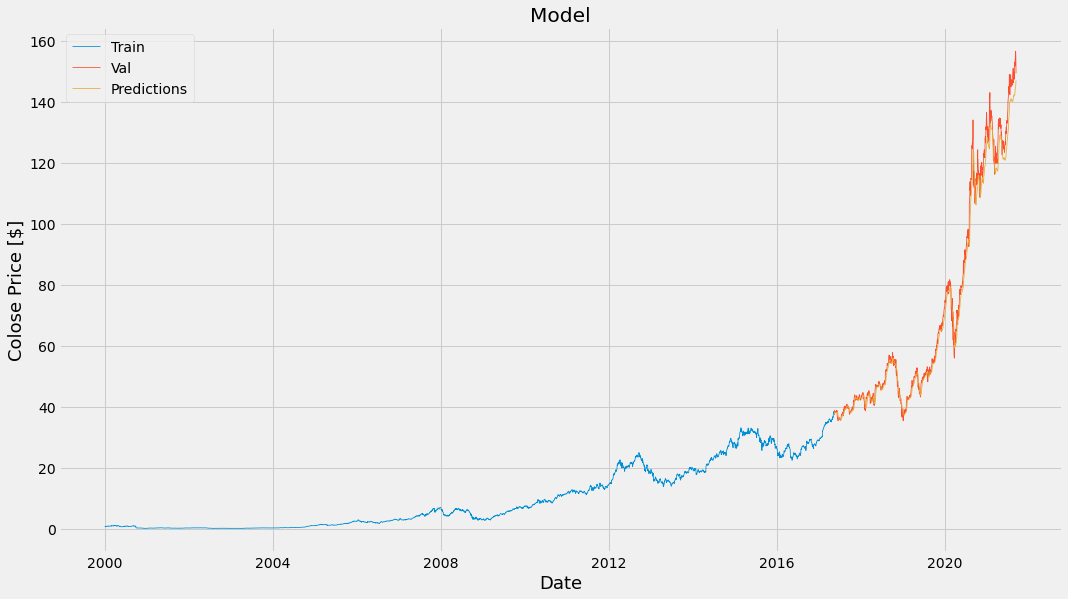

In [21]:
# plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,9))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Colose Price [$]', fontsize=18)
plt.plot(train['Close']["2000-01-01":], linewidth=0.8)
plt.plot(valid[['Close', 'Predictions']], linewidth=0.8)
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()